<a href="https://colab.research.google.com/github/su-sumico/seminar/blob/main/bert_ldnews_classification_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

livedoor ニュース記事データセットによる文章分類モデルの学習（評価）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !mkdir -p '/content/drive/My Drive/bert/'
%cd '/content/drive/My Drive/bert/'

!git clone https://github.com/huggingface/transformers
%cd transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/bert
fatal: destination path 'transformers' already exists and is not an empty directory.
/content/drive/My Drive/bert/transformers


In [ ]:
!pip install transformers fugashi ipadic sentencepiece datasets

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# トークナイザの取得
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/bert/text/news_model')

# モデルの取得
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
    .from_pretrained('/content/drive/MyDrive/bert/text/news_model')
    .to(device))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/bert/text/news_test.csv",encoding='cp932')
test_df[:10]

,label,sentence
0,2,【Sports Watch】星野監督、すっ呆ける「まあ、そういう風に言われていますね」
1,3,嘘泣きじゃない！ 柳美里が北朝鮮市民の涙のワケを解説【話題】
2,6,【終了しました】ぷるっと肌へシュッ！「白桃肌 ホワイトニングミスト」を3名様にプレゼント
3,4,ユナイテッドアローズに学ぶ、ワンランク上のスタイリング術【新生活特集】
4,5,沢尻エリカがしっちゃかめっちゃか、掟破りの特報映像が公開
5,0,結婚に必要な「覚悟」とは？
6,8,【韓国ニュース】月一で来日し、日本全国でデモする韓国の農民とは
7,7,【スマホ美女インタビュー】″きれいなお姉さんが使っていたから″という理由でiPhoneを使い...
8,0,その後の結婚生活を占う披露宴での費用分担
9,7,ソフトバンク向けシャープ製の今夏モデルはどれも魅力的！シャープ開発陣に「AQUOS PHON...


In [ ]:
sample_text = test_df['sentence'][1]
sample_text

'嘘泣きじゃない！\u3000柳美里が北朝鮮市民の涙のワケを解説【話題】'

In [ ]:
inputs = tokenizer(sample_text, return_tensors="pt")
labels =['dokujo', 'it', 'sports-','kaden','homme','movie','peachy','smax','topic-news']
model.eval()

with torch.no_grad():
    outputs = model(inputs["input_ids"].to(device), inputs["attention_mask"].to(device))
    prediction = torch.nn.functional.softmax(outputs.logits,dim=1)

In [ ]:
print(int(torch.argmax(prediction)))
print(labels[int(torch.argmax(prediction))])

3
kaden


In [ ]:
print(prediction.cpu().detach().numpy())

[[1.3191085e-03 1.9423759e-03 3.3686415e-03 9.8552948e-01 2.8338104e-03
  1.3766168e-03 7.5158424e-04 1.3940047e-03 1.4843496e-03]]


In [ ]:
print(np.max(prediction.cpu().detach().numpy()))

0.9855295


In [ ]:
df = pd.DataFrame(columns=['label','pred', 'sentence'])
for sentence in test_df['sentence']:
  inputs = tokenizer(sentence, return_tensors="pt")
  labels =['dokujo', 'it', 'sports-','kaden','homme','movie','peachy','smax','topic-news']
  model.eval()

  with torch.no_grad():
      outputs = model(inputs["input_ids"].to(device), inputs["attention_mask"].to(device))
      prediction = torch.nn.functional.softmax(outputs.logits,dim=1)
      df = df.append({'label':labels[int(torch.argmax(prediction))] ,'pred':np.max(prediction.cpu().detach().numpy()),'sentence':sentence}, ignore_index=True)

<ipython-input-28-65a547d94d50>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'label':labels[int(torch.argmax(prediction))] ,'pred':np.max(prediction.cpu().detach().numpy()),'sentence':sentence}, ignore_index=True)
<ipython-input-28-65a547d94d50>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'label':labels[int(torch.argmax(prediction))] ,'pred':np.max(prediction.cpu().detach().numpy()),'sentence':sentence}, ignore_index=True)
<ipython-input-28-65a547d94d50>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'label':labels[int(torch.argmax(prediction))] ,'pred':np.max(prediction.cpu().detach().numpy()),'sentence':sentence}, ignore_index=True)
<ipython-input-28-65a547d94d

In [ ]:
df

,label,pred,sentence
0,sports-,0.982159,【Sports Watch】星野監督、すっ呆ける「まあ、そういう風に言われていますね」
1,kaden,0.985529,嘘泣きじゃない！ 柳美里が北朝鮮市民の涙のワケを解説【話題】
2,peachy,0.943519,【終了しました】ぷるっと肌へシュッ！「白桃肌 ホワイトニングミスト」を3名様にプレゼント
3,homme,0.930679,ユナイテッドアローズに学ぶ、ワンランク上のスタイリング術【新生活特集】
4,movie,0.971727,沢尻エリカがしっちゃかめっちゃか、掟破りの特報映像が公開
...,...,...,...
733,it,0.742115,一夜限り！広末涼子ら出演の懐かしいドコモCMがオンエア
734,topic-news,0.930054,削除要請を放置、2ちゃんねるを強制捜査
735,peachy,0.735810,「クリスピー・クリーム・ドーナツ」が玉川高島屋S・Cにやってくる！
736,movie,0.971851,椿鬼奴が弓でヴァンパイア退治「ハリウッドに進出したい」


In [ ]:
df.to_csv("/content/drive/MyDrive/bert/text/news_test_result.csv",encoding='UTF-8')

In [ ]:
y_true = []
y_pred = []

for item in zip(test_df['label'], test_df['sentence']):
  inputs = tokenizer(item[1], return_tensors="pt")
  labels =['dokujo', 'it', 'sports-','kaden','homme','movie','peachy','smax','topic-news']
  model.eval()

  with torch.no_grad():
      outputs = model(inputs["input_ids"].to(device), inputs["attention_mask"].to(device))
      prediction = torch.nn.functional.softmax(outputs.logits,dim=1)
      y_true.append(item[0])
      y_pred.append(int(torch.argmax(prediction)))

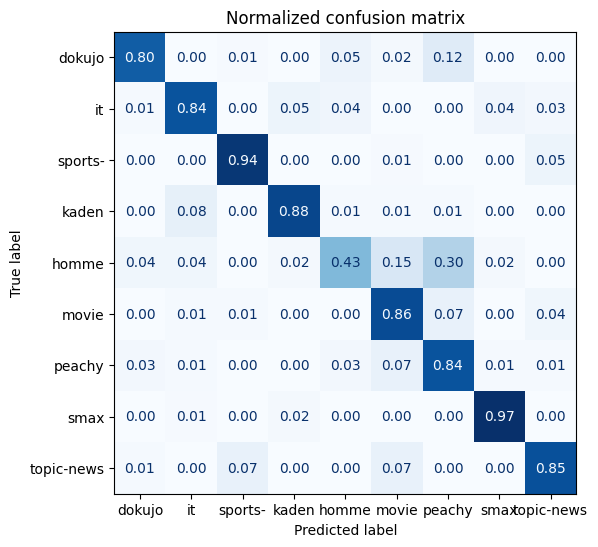

In [ ]:
labels =['dokujo', 'it', 'sports-','kaden','homme','movie','peachy','smax','topic-news']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_pred, y_true,labels)

In [ ]:
from sklearn.metrics import classification_report
labels =['dokujo', 'it', 'sports-','kaden','homme','movie','peachy','smax','topic-news']
report = classification_report(y_true, y_pred,target_names=labels,output_dict=True)

report_df = pd.DataFrame(report).T
report_df

,precision,recall,f1-score,support
dokujo,0.925926,0.797872,0.857143,94.000000
it,0.846154,0.835443,0.840764,79.000000
sports-,0.931373,0.940594,0.935961,101.000000
kaden,0.915663,0.883721,0.899408,86.000000
homme,0.676471,0.433962,0.528736,53.000000
movie,0.752688,0.864198,0.804598,81.000000
peachy,0.663366,0.837500,0.740331,80.000000
smax,0.946809,0.967391,0.956989,92.000000
topic-news,0.847222,0.847222,0.847222,72.000000
accuracy,0.842818,0.842818,0.842818,0.842818
